In [1]:
using AutoRisk
using AutoViz
using CommandLineFlags
using Interact
using Reel
Reel.set_output_type("gif");
include("../collection/collect_heuristic_dataset.jl");

In [8]:
# extract config from dataset
dataset_filepath = "../../data/datasets/test.h5"
flags = h5readattr(dataset_filepath, "risk")
fixup_types!(flags)
flags["num_monte_carlo_runs"] = 1
col = build_dataset_collector("", flags);

In [9]:
# set config manually - I'd say if you're not sure, prob don't change or run this
# include("../collection/heuristic_dataset_config.jl")
# parse_flags!(FLAGS, [])
# FLAGS["num_monte_carlo_runs"] = 1
# FLAGS["prime_time"] = 10.
# FLAGS["sampling_time"] = 5.
# # FLAGS["roadway_type"] = "straight"
# # FLAGS["roadway_length"] = 10000.
# # FLAGS["roadway_length"] =  1000.
# # FLAGS["roadway_type"] =  "straight"
# # FLAGS["min_num_vehicles"] =  200
# # FLAGS["max_num_vehicles"] =  200
# # FLAGS["min_base_speed"] =  10.
# # FLAGS["max_base_speed"] =  10.
# # FLAGS["min_init_dist"] =  15.
# # FLAGS["overall_response_time"] = 0.2
# # FLAGS["lon_response_time"] = 0.2
# FLAGS["err_p_a_to_i"] =  0.05
# FLAGS["err_p_i_to_a"] =  0.3
# # FLAGS["min_init_dist"] =  15.
# # FLAGS["max_init_dist"] =  5.
# # FLAGS["num_lanes"] = 3
# # FLAGS["behavior_type"] = "heuristic"
# # FLAGS["driver_network_filepath"] = "../../data/policies/gail_gru.h5"
# FLAGS["extractor_type"] =  "multi"
# FLAGS["extract_road_lidar"] =  false
# col = build_dataset_collector("", FLAGS);


In [10]:
function Base.show(col::DatasetCollector, seed::Int; target_idx::Int = 1)
    if target_idx <= size(col.eval.targets, 1)
        # this is labeled collisions, but can be any target, selected by target_idx
        in_collision_veh_idxs = find(col.eval.targets[target_idx,:] .== 1.)
    else
        in_collision_veh_idxs = []
    end
    
    # if no collisions then still display the scene, but change car colors
    collisions_exist = in_collision_veh_idxs == [] ? false : true
    collision_color = collisions_exist ? colorant"red" : colorant"orange"
    if !collisions_exist
        in_collision_veh_idxs = sort(collect(values(col.eval.veh_id_to_idx)))
    end
    
    # prepare film for save case
    frames = Frames(MIME("image/png"), fps=10)
    
    # display the record
    @manipulate for follow_veh_idx in in_collision_veh_idxs,
                zoom in collect(1.:2:20.),
                i in 1:(col.eval.rec.nframes),
                save in [false, true],
                clear in [false, true]
        
        i -= 1
        # set camera
        follow_veh_id = -1
        if follow_veh_idx == 0
            cam = FitToContentCamera()
        else
            for (veh_id, veh_idx) in col.eval.veh_id_to_idx
                if veh_idx == follow_veh_idx
                    follow_veh_id = veh_id
                    break
                end
            end
            cam = AutoViz.CarFollowCamera{Int}(follow_veh_id, zoom)
        end

        # render scene
        idx = -(col.eval.rec.nframes - i) + 1
        carcolors = Dict{Int,Colorant}()
        for veh in col.eval.rec[idx]
            carcolors[veh.id] = veh.id == follow_veh_id ? collision_color : colorant"green"
        end
        mlane = 0
        if typeof(col.models[follow_veh_id]) == DelayedDriver
            mlane = col.models[follow_veh_id].driver.mlane
        elseif typeof(col.models[follow_veh_id]) == Tim2DDriver
            mlane = col.models[follow_veh_id].mlane
        else
            mlane = nothing
        end
        
        stats = follow_veh_id == -1 ? [] : [
            CarFollowingStatsOverlay(follow_veh_id, 2), 
            NeighborsOverlay(follow_veh_id, textparams = TextParams(x = 600, y_start=300))]
        
        if false && mlane != nothing && typeof(mlane) == MOBIL
            push!(stats, MOBILOverlay(follow_veh_id, mlane))
        end
        
        frame = render(col.eval.rec[idx], col.roadway, stats,
            cam = cam, car_colors = carcolors)
        push!(frames, frame)
        
        # to use the save, move around the slider above and collect some frames to write
        # then switch to save, then switch off save
        # this will write the frames, and then clear them
        if save
            filename = "seed_$(seed)_veh_id_$(follow_veh_idx)_target_$(target_idx)"
            write("../../data/visualizations/outputs/$(filename).gif", frames)
            frames = Frames(MIME("image/png"), fps=2)
        end
        
        # to clear frames without saving them set this to true then false
        if clear
            frames = Frames(MIME("image/png"), fps=10)
        end
        
        frame
    end

end

In [11]:
seed = 1
rand!(col, seed)
evaluate!(col.eval, col.scene, col.models, col.roadway, seed);

Interact.Options{:ToggleButtons,Int64}(input-6: Signal{Int64}(5, nactions=1),"follow_veh_idx",5,"5",Interact.OptionDict(DataStructures.OrderedDict("5"=>5,"9"=>9,"15"=>15,"25"=>25,"29"=>29,"30"=>30,"40"=>40,"44"=>44),Dict(9=>"9",25=>"25",29=>"29",40=>"40",5=>"5",15=>"15",44=>"44",30=>"30")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(input-7: Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(input-8: Signal{Int64}(27, nactions=1),"i",27,"27",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(input-9: Signal{Bool}(false, nactions=1),"save",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(input-10: Signal{Bool}(false, nactions=1),"clear",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

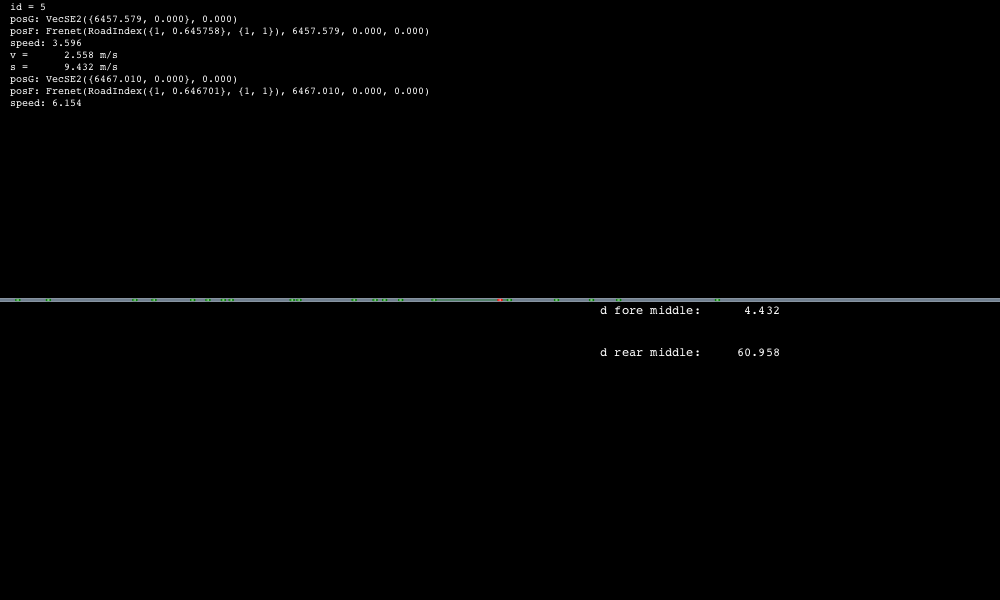

In [12]:
show(col, seed, target_idx = 2)

In [13]:
println(col.models[2])

AutoRisk.ErrorableDriverModel(AutoRisk.DelayedDriver(AutomotiveDrivingModels.Tim2DDriver(SceneRecord(nscenes=2),AutomotiveDrivingModels.IntelligentDriverModel
  a: Float64 2.4838824763743035
  σ: Float64 0.0
  k_spd: Float64 1.4999876388816966
  δ: Float64 4.0
  T: Float64 1.7499690972042417
  v_des: Float64 34.99975277763393
  s_min: Float64 4.999975277763394
  a_max: Float64 3.99992583329018
  d_cmf: Float64 2.49996291664509
  d_max: Float64 9.0
,AutomotiveDrivingModels.ProportionalLaneTracker(-0.0,0.0,3.499987638881697,2.499987638881697),AutomotiveDrivingModels.MOBIL(0,SceneRecord(nscenes=2),AutomotiveDrivingModels.IntelligentDriverModel
  a: Float64 1.939955071331007
  σ: Float64 NaN
  k_spd: Float64 1.0
  δ: Float64 4.0
  T: Float64 1.5
  v_des: Float64 34.99975277763393
  s_min: Float64 5.0
  a_max: Float64 3.0
  d_cmf: Float64 2.0
  d_max: Float64 9.0
,2.0,0.4999901111053574,0.6999829416567414)),SceneRecord(nscenes=11),1.0,-10),true,0.01,0.3,MersenneTwister(UInt32[0x016d9284],Ba

In [ ]:
println(mean(col.eval.agg_targets, 2))

In [ ]:
println(mean(col.eval.features, 3))